# Predicting Titanic Survivors with Classification Trees

#### Derek Lilienthal

## Introduction
_I will be using Classification Trees to try to predict the survivors on the Titanic_

source: https://www.kaggle.com/c/titanic/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set(font_scale=2)
sns.set(color_codes=True)

C:\Users\dlili\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Reading and preprocessing the data

In [2]:
input_file = "https://raw.githubusercontent.com/grbruns/cst383/master/titanic.csv"
df = pd.read_csv(input_file)

# column PassengerId
# a unique numeric passenger ID; not needed
df.drop('PassengerId', axis=1, inplace=True)

# column Cabin
# use only first letter of Cabin
df['Cabin'] = df['Cabin'].str.slice(stop=1)
df['Cabin'].fillna('U', inplace=True)

# column Ticket
# use two categories: tickets containing letters and
# tickets containing only digits
df['Ticket'] = df['Ticket'].str.contains('[a-zA-Z]')

# column Embarked
# hardly any NA embarked values, so drop rows containing them
df.dropna(subset=['Embarked'], inplace=True)

# column Name
# retain only the title of the name, if present
def extract_title(s):
    titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.']
    for title in titles:
        if title in s:
            return title
    return 'NoTitle'

df['Title'] = df['Name'].apply(extract_title)
df.drop('Name', axis=1, inplace=True)

# column Age
# fill with median value
df['Age'].fillna(df['Age'].median(), inplace=True)

# confirm that no NA values remain
df.isna().mean()
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    Int64  
 1   Pclass    889 non-null    string 
 2   Sex       889 non-null    string 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    Int64  
 5   Parch     889 non-null    string 
 6   Ticket    889 non-null    boolean
 7   Fare      889 non-null    string 
 8   Cabin     889 non-null    string 
 9   Embarked  889 non-null    string 
 10  Title     889 non-null    string 
dtypes: Int64(2), boolean(1), float64(1), string(7)
memory usage: 79.9 KB


## Data exploration

In [3]:
sns.set(font_scale=2)
sns.set(font_scale=2)

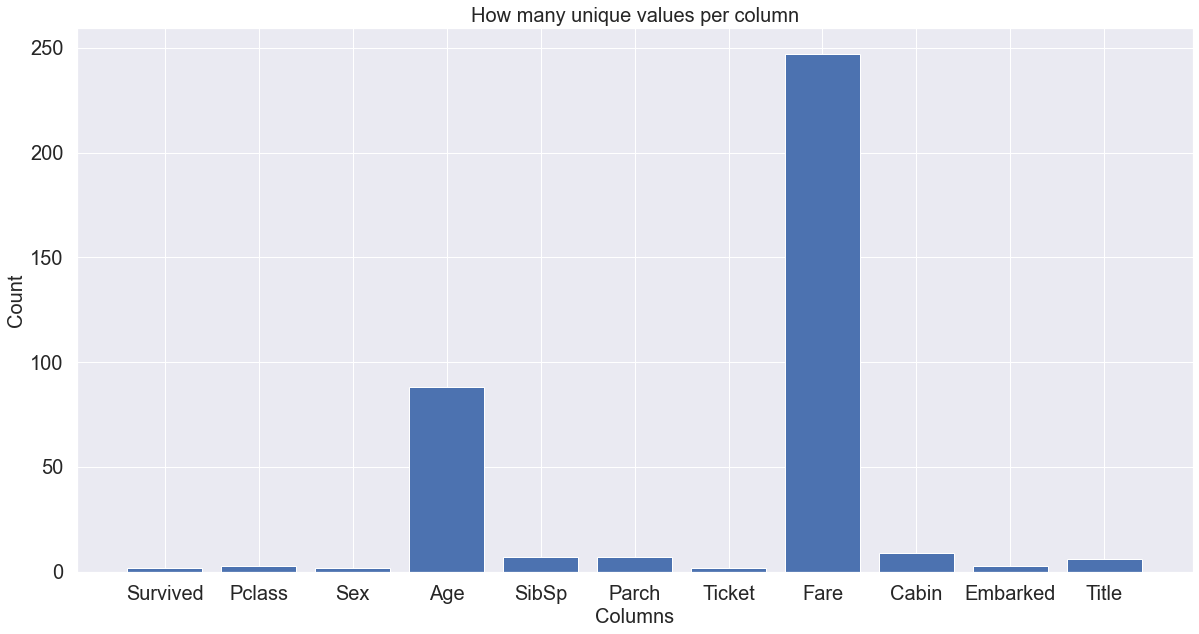

In [4]:
# How many unique values there are in each column
temp_dict = {}
for col in df.columns:
    temp_dict[col] = df[col].unique().size

plt.bar(temp_dict.keys(),temp_dict.values())
plt.title('How many unique values per column', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Columns', fontsize=20)
plt.ylabel('Count', fontsize=20);

With Age and Fare having such a large amount of unique values, it would not be feasible to graph those as a 

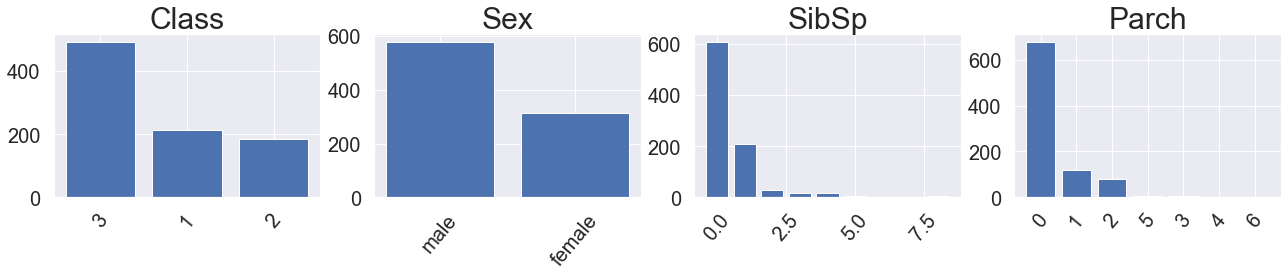

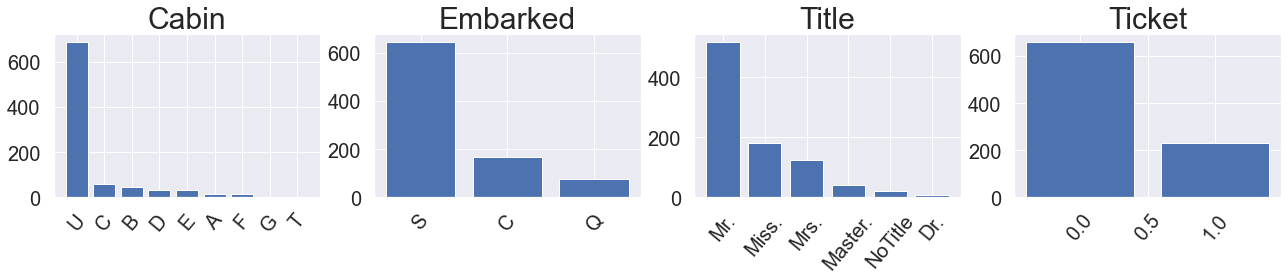

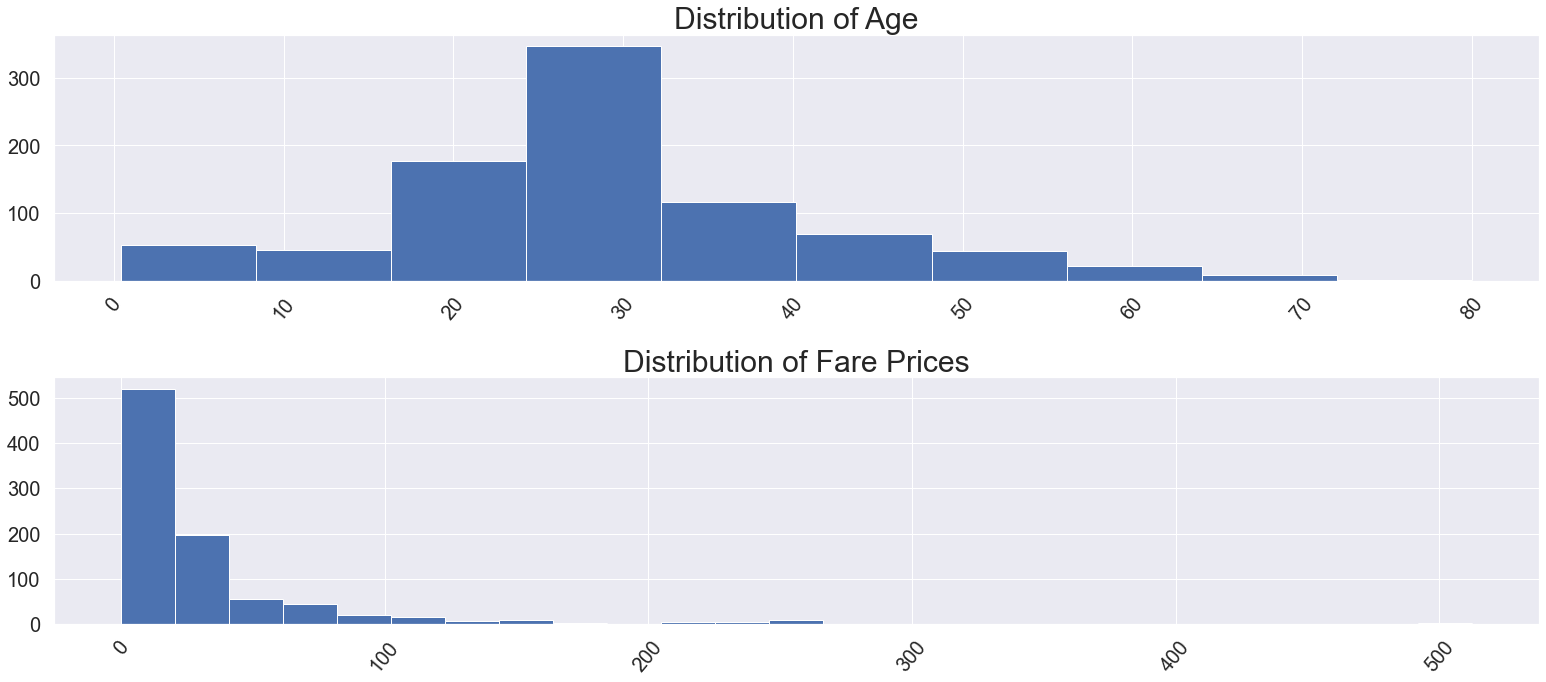

In [5]:
dict_list = []
for col in df.columns:
    if ((col == 'Age') | (col == 'Fare') | (col == 'Survived')):
        continue
    temp = df[col].value_counts(sort=False)
    dict_list.append(temp.to_dict())
 
# Graph all the stuff
fig, axs = plt.subplots(1, 4, figsize=(22, 3))
row_1_titles = ['Class','Sex','SibSp','Parch']
row_2_titles = ['Cabin','Embarked','Title','Ticket']
for i in range(4):
    axs[i].bar(dict_list[i].keys(),dict_list[i].values())
    axs[i].tick_params(axis='x', which='both', labelsize=20, labelbottom=True, rotation=50)
    axs[i].tick_params(axis='y', labelsize=20)
    axs[i].set_title(row_1_titles[i], fontsize=30)

fig, axs = plt.subplots(1, 4, figsize=(22, 3))
for i in range(4,8):
    axs[i-5].bar(dict_list[i].keys(),dict_list[i].values())
    axs[i-5].tick_params(axis='x', which='both', labelsize=20, labelbottom=True, rotation=50)
    axs[i-5].tick_params(axis='y', labelsize=20)
    axs[i-5].set_title(row_2_titles[i-5], fontsize=30)
    
fig, axs = plt.subplots(2, 1, figsize=(22, 10))
axs[0].hist(df['Age'])
axs[0].set_title('Distribution of Age', fontsize=30)
axs[0].tick_params(axis='x', which='both', labelsize=20, labelbottom=True, rotation=50)
axs[0].tick_params(axis='y', labelsize=20)
axs[1].hist(df['Fare'].astype(float), bins=25)
axs[1].set_title('Distribution of Fare Prices', fontsize=30)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].tick_params(axis='x', which='both', labelsize=20, labelbottom=True, rotation=50)
fig.tight_layout();
#axs[1].set_xticks(np.linspace(0,int(float(max(df['Fare'].values))),20));

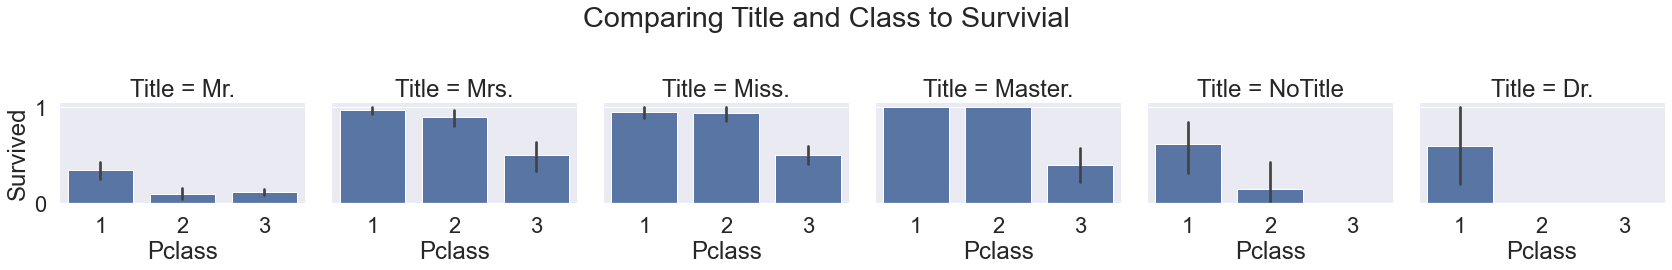

In [6]:
g = sns.FacetGrid(df, col="Title", height=4, aspect=1)
g.map(sns.barplot, "Pclass", "Survived", order=["1","2","3"])
g.fig.suptitle("Comparing Title and Class to Survivial")
g.tight_layout();

From the plot above, it is apparent that first class 

In [7]:
def percentSurvived2(df, column):
    df1 = df.groupby(column)['Survived'].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('Percent').reset_index()
    return df1

In [8]:
# Create a function to numeric variable into ranges of 10
def func(df):
    return(df - (df % 10))

In [9]:
df3 = df.copy()
df3['Fare'] = df3['Fare'].astype(float)
df3['Fare'] = df3['Fare'].apply(func)
df3['Age'] = df3['Age'].astype(float)
df3['Age'] = df3['Age'].apply(func)

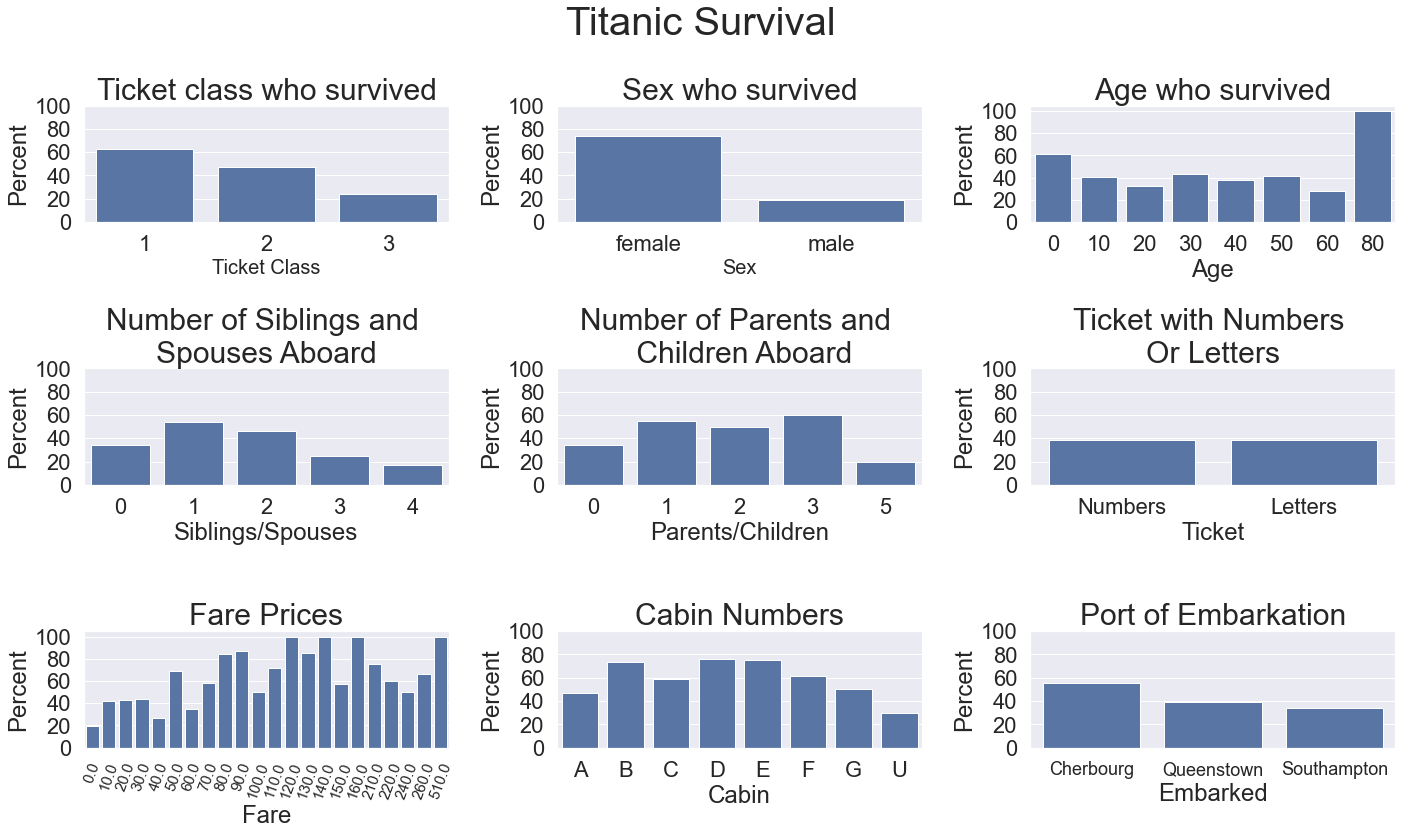

In [10]:
fig, axes = plt.subplots(3,3)
col = df.columns.tolist()[1:]
fig.set_size_inches(20, 12)
sns.set(font_scale=2)

# Set the y-ticks
y_ticks = np.arange(6)*20
x_font_size = 20

# Pclass
temp_df = percentSurvived2(df, col[0])
sns.barplot(x=col[0], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[0,0]).set_title('Ticket class who survived', fontsize=30)
axes[0,0].set_yticks(y_ticks)
axes[0,0].set_xlabel('Ticket Class', fontsize=x_font_size)

# Sex
temp_df = percentSurvived2(df, col[1])
sns.barplot(x=col[1], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[0,1]).set_title('Sex who survived', fontsize=30)
axes[0,1].set_yticks(y_ticks)
axes[0,1].set_xlabel('Sex', fontsize=x_font_size)

# Age
temp_df = percentSurvived2(df3, col[2])
sns.barplot(x=col[2], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[0,2]).set_title('Age who survived', fontsize=30)
axes[0,2].set_yticks(y_ticks)
axes[0,2].set_xticklabels([0,10,20,30,40,50,60,80])

# Number of Siblinings
temp_df = percentSurvived2(df, col[3])
sns.barplot(x=col[3], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[1,0]).set_title('Number of Siblings and \nSpouses Aboard', fontsize=30)
axes[1,0].set_yticks(y_ticks)
axes[1,0].set_xlabel('Siblings/Spouses')

# Number of parents/Children
temp_df = percentSurvived2(df, col[4])
sns.barplot(x=col[4], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[1,1]).set_title('Number of Parents and \n Children Aboard', fontsize=30)
axes[1,1].set_yticks(y_ticks)
axes[1,1].set_xlabel('Parents/Children')

# Ticket Number/Letters
temp_df = percentSurvived2(df, col[5])
sns.barplot(x=col[5], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[1,2]).set_title('Ticket with Numbers \nOr Letters', fontsize=30)
axes[1,2].set_yticks(y_ticks)
axes[1,2].set_xticklabels(['Numbers','Letters'])

# Fare Price
temp_df = percentSurvived2(df3, col[6])
sns.barplot(x=col[6], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[2,0]).set_title('Fare Prices', fontsize=30)
axes[2,0].set_xticklabels(temp_df['Fare'].loc[temp_df['Survived']==1],fontsize=15, rotation=70)
axes[2,0].set_yticks(y_ticks)

# Cabin Number
temp_df = percentSurvived2(df, col[7])
sns.barplot(x=col[7], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[2,1]).set_title('Cabin Numbers', fontsize=30)
axes[2,1].set_yticks(y_ticks)
axes[2,1].set_xlabel('Cabin')

# Port of Embarkation
temp_df = percentSurvived2(df, col[8])
sns.barplot(x=col[8], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1], ax=axes[2,2]).set_title('Port of Embarkation', fontsize=30)
axes[2,2].set_yticks(y_ticks)
axes[2,2].set_xticklabels(['Cherbourg','Queenstown','Southampton'], fontsize=18)

axes[0,0].legend().set_visible(False)
axes[0,1].legend().set_visible(False)
axes[0,2].legend().set_visible(False)
axes[1,0].legend().set_visible(False)
axes[1,1].legend().set_visible(False)
axes[1,2].legend().set_visible(False)
axes[2,0].legend().set_visible(False)
axes[2,1].legend().set_visible(False)
axes[2,2].legend().set_visible(False)
fig.suptitle('Titanic Survival', fontsize=40)
fig.tight_layout();

Some of the notable things from the plot above is that people who were in first class had a higher chance of survival, Females survived more often than men, the really young and really old seemed to survive more than everyone else, there is almost no difference in survival in whether your ticket was all numbers or letters, and it seems the more people paid in fare, the more likely you were to survive.

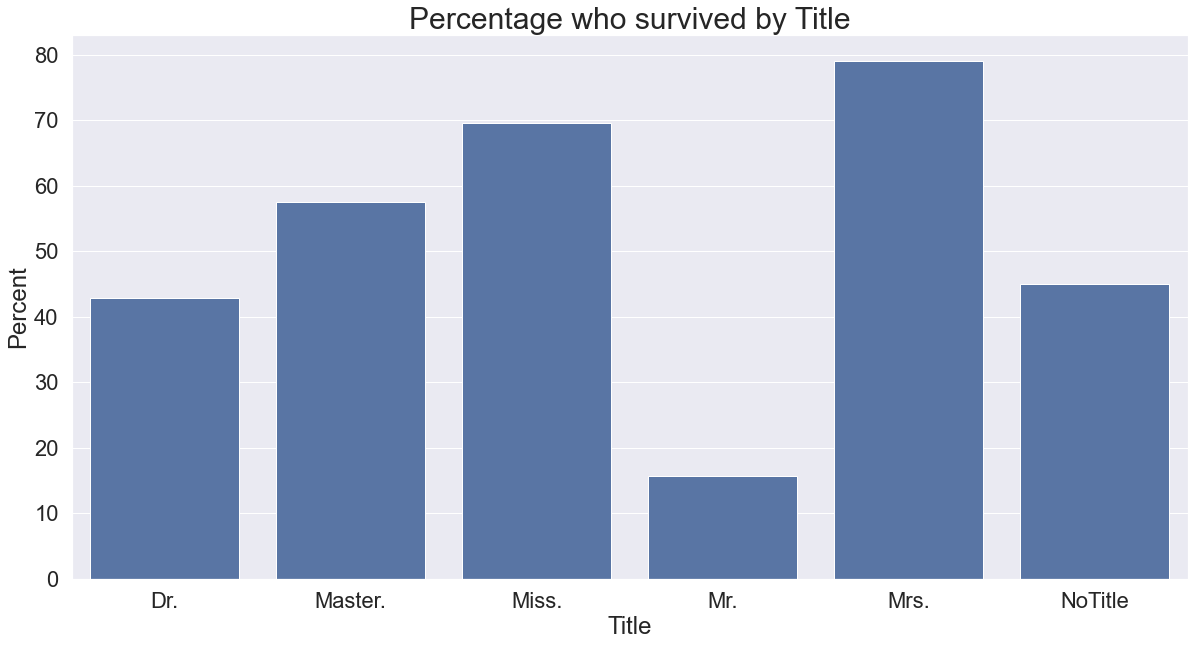

In [11]:
temp_df = percentSurvived2(df, col[9])
ax = sns.barplot(x=col[9], y="Percent", hue='Survived', data=temp_df.loc[temp_df['Survived'] == 1]).set_title('Percentage who survived by Title', fontsize=30)
plt.legend().set_visible(False);

There is a disproportional amount of men with the title Mr. who did not survive compared to women with a title of Mrs. and Miss. 

## Building a classification tree

In [13]:
np.random.seed(123)

In [14]:
### Create a new dataframe with all the categorical data represented numerically

# First, create a new dataframe so we don't modify the original
df2 = df.copy()

# Create some Label Encoder objects for all of our variables that are not numeric
le_sex = LabelEncoder()
le_ticket = LabelEncoder()
le_cabin = LabelEncoder()
le_embarked = LabelEncoder()
le_title = LabelEncoder()

# Create new columns in our dataframe with the transformed data
df2['Sex_n'] = le_sex.fit_transform(df2['Sex'])
df2['Ticket_n'] = le_sex.fit_transform(df2['Ticket'])
df2['Cabin_n'] = le_sex.fit_transform(df2['Cabin'])
df2['Embarked_n'] = le_sex.fit_transform(df2['Embarked'])
df2['Title_n'] = le_sex.fit_transform(df2['Title'])

# Convert all datatypes that are not numeric (but actually are) into numeric
df2['Pclass'] = df2['Pclass'].astype(int)
df2['Parch'] = df2['Parch'].astype(int)
df2['Fare'] = df2['Fare'].astype(float)

# Drop all the old columns 
df2 = df2.drop(['Sex','Ticket','Cabin','Embarked','Title'], axis='columns')
df2.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_n,Ticket_n,Cabin_n,Embarked_n,Title_n
0,0,3,22.0,1,0,7.2500,1,1,8,2,3
1,1,1,38.0,1,0,71.2833,0,1,2,0,4
2,1,3,26.0,0,0,7.9250,0,1,8,2,2
3,1,1,35.0,1,0,53.1000,0,0,2,2,4
4,0,3,35.0,0,0,8.0500,1,0,8,2,3


### Splitting the Data

In [15]:
# Create spit
predictors = df2.columns[1:] # Grab all the columns except for our target
target = 'Survived'
X = df2[predictors].values # Convert to numpy array
y = df2[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) # Split our data

#### Creating a Classification Tree

In [16]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0) # Create the tree
clf.fit(X_train, y_train) # Train the tree

DecisionTreeClassifier(max_depth=2, random_state=0)

In [17]:
text_representation = tree.export_text(clf, feature_names=predictors.tolist())
print(text_representation)

|--- Sex_n <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- class: 0
|--- Sex_n >  0.50
|   |--- Title_n <= 2.00
|   |   |--- class: 1
|   |--- Title_n >  2.00
|   |   |--- class: 0



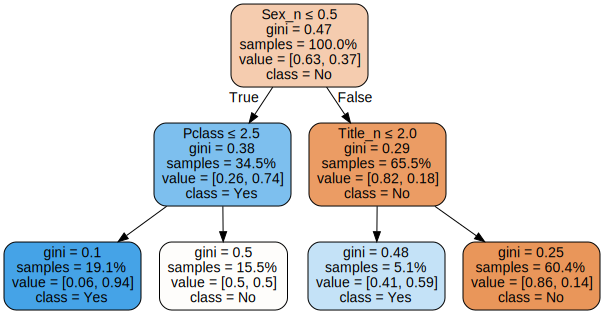

In [18]:
# Graph the tree
target_names = ['No','Yes']
dot_data = export_graphviz(clf, precision=2,
                          feature_names=predictors,
                          proportion=True,
                          class_names=target_names,
                          filled=True, rounded=True,
                          special_characters=True)

graph = graphviz.Source(dot_data)
graph

To interpret the tree, the root node uses Sex as the first filter. In particular, if sex is less than 0.5 (is female), then it goes to the left. Otherwise, it goes to the right. On the next level (depth 1) on the right, the next filter it uses is if you are either first or second class, then go to the left, otherwise (if you're 3rd class) go to the right. For the right depth 1 node, it uses Title as a filter. For this node, if you're at Doctor or Master, then go to the left node, otherwise, go to the right. Because the max_depth was only set to 2, the tree stops growing at a depth of 2. This would severely under-fit the data and we can see this happening by the 'value' in the middle two nodes where those nodes both have the Yes and No very close to each other. 

## Making predictions and assessing your model

Our baseline accuracy is computed by creating an array of all 0's (did not survive) and comparing it against our test data.

In [47]:
print("Our baseline accuracy is {:.2f}%".format((np.zeros(y_test.shape[0], dtype=int) == y_test).mean() * 100))

Our baseline accuracy is 59.19%


In [20]:
# Check our predictions based on the first model we used where we used all the columns and only made our max_depth=2
y_predict = clf.predict(X_test)

# Check for accuracy
print("Our first models accuracy is {:.2f}%".format((y_predict == y_test).mean() * 100))

Our first models accuracy is 74.89%


Confusion matrix

In [21]:
def print_conf_mtx(y_true, y_pred, classes=None):
    """ Print a confusion matrix (two classes only). """
    
    if not classes:
        classes = ['neg', 'pos']
   	 
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left   	= '{:<10s}'.replace('10',str(n))
    right  	= '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    
    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))

print_conf_mtx(y_test, y_predict, classes=target_names)

       predicted 
actual    No  Yes
No       123    9
Yes       47   44


We have 47 cases where the model predicted No for survival (when in fact they did survive) and 9 cases where the model predicted Yes for survival (when in fact they did not). 

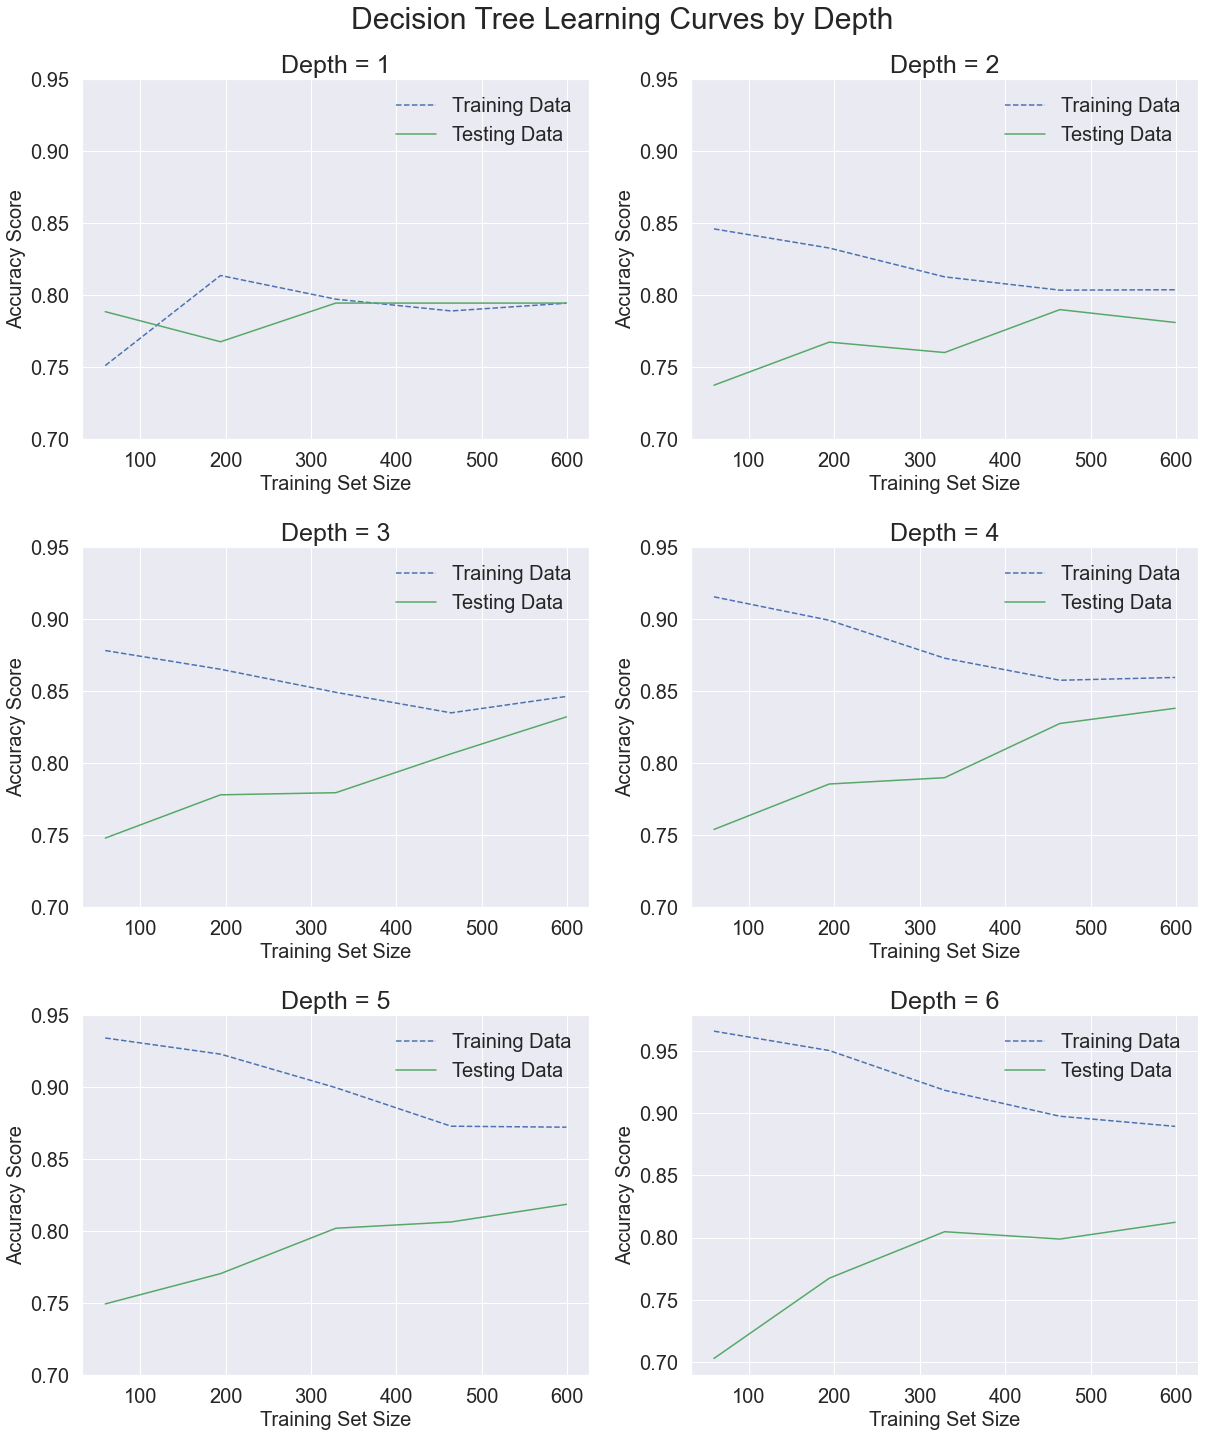

In [22]:
def DTC_plot(ax, depth):
    train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(max_depth=depth, random_state=0), 
                                                            X_train, y_train, 
                                                            cv=10, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curve
    ax.plot(train_sizes, train_scores_mean,'--', color="b", label='train')
    ax.plot(train_sizes, test_scores_mean, label='test', color="g")
    ax.set_xlabel('Training Set Size', fontsize=20)
    ax.set_ylabel('Accuracy Score', fontsize=20)
    ax.set_title('Depth = '+str(depth), fontsize=25)
    ax.set_yticks([0.70,0.75,0.80,0.85,0.90,0.95])
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.legend(['Training Data','Testing Data'], fontsize=20)
    
fig, axs = plt.subplots(nrows=3, ncols=2, constrained_layout=False)
for i, ax in enumerate(axs.flat):
    DTC_plot(ax, i+1)
fig.subplots_adjust(hspace=0.3, wspace=0.2, top=2, bottom=0.2)
fig.suptitle('Decision Tree Learning Curves by Depth', y=2.1, size=30);

As we increase the depth size of our model, there is a trend that is apparent.

At a depth of only 1, both the training and test learning curves overlap and cross over because the model only has has one feature it can use as a filter for prediction. This is as case of severe under-fitting 

From depths 2 to 4, both the training learning curve and testing 

## Model 2

For this model, i decided to use a Grid Search in order to find the best parameters for the model

In [23]:
params = {'max_leaf_nodes': list(range(2, 100)),
          'min_samples_split': [2, 3, 4, 5],
          'max_depth': list(range(2,9))} 

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                              params, verbose=1, cv=5, n_jobs=-1)
grid_search_cv.fit(X_train, y_train);

Fitting 5 folds for each of 2744 candidates, totalling 13720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1048 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 13350 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 13720 out of 13720 | elapsed:    7.3s finished


In [24]:
grid_search_cv.best_params_

{'max_depth': 7, 'max_leaf_nodes': 26, 'min_samples_split': 4}

Our best parameters from the grid search are:

max_depth= 7, max_leaf_nodes = 26, and min_samples_split = 4

In [25]:
# Create a new tree with the best parameters
clf = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=26, min_samples_split=4, random_state=0) # Create the tree
clf.fit(X_train, y_train) # Train the tree

# Check our predictions
y_predict = clf.predict(X_test)

# Check our accuracy
print("Our Second models accuracy is {:.2f}%".format((y_predict == y_test).mean() * 100))

Our Second models accuracy is 79.37%


_Our first models accuracy was only 74.89%_

_Our baseline accuracy was only 59.19%_

In [26]:
text_representation = tree.export_text(clf, feature_names=predictors.tolist())
print(text_representation)

|--- Sex_n <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Age <= 2.50
|   |   |   |--- class: 0
|   |   |--- Age >  2.50
|   |   |   |--- Fare <= 28.86
|   |   |   |   |--- Fare <= 28.23
|   |   |   |   |   |--- Age <= 56.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Age >  56.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Fare >  28.23
|   |   |   |   |   |--- class: 0
|   |   |   |--- Fare >  28.86
|   |   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Fare <= 23.35
|   |   |   |--- Age <= 35.00
|   |   |   |   |--- Fare <= 7.89
|   |   |   |   |   |--- Parch <= 1.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Parch >  1.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Fare >  7.89
|   |   |   |   |   |--- Fare <= 10.82
|   |   |   |   |   |   |--- Age <= 19.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Age >  19.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--

In [27]:
print_conf_mtx(y_test, y_predict, classes=target_names)

       predicted 
actual    No  Yes
No       114   18
Yes       28   63


Our second model has now predicted 28 cases where someone actually died but predicted survival and 18 cases where we predicted someone lived when they actually died. 

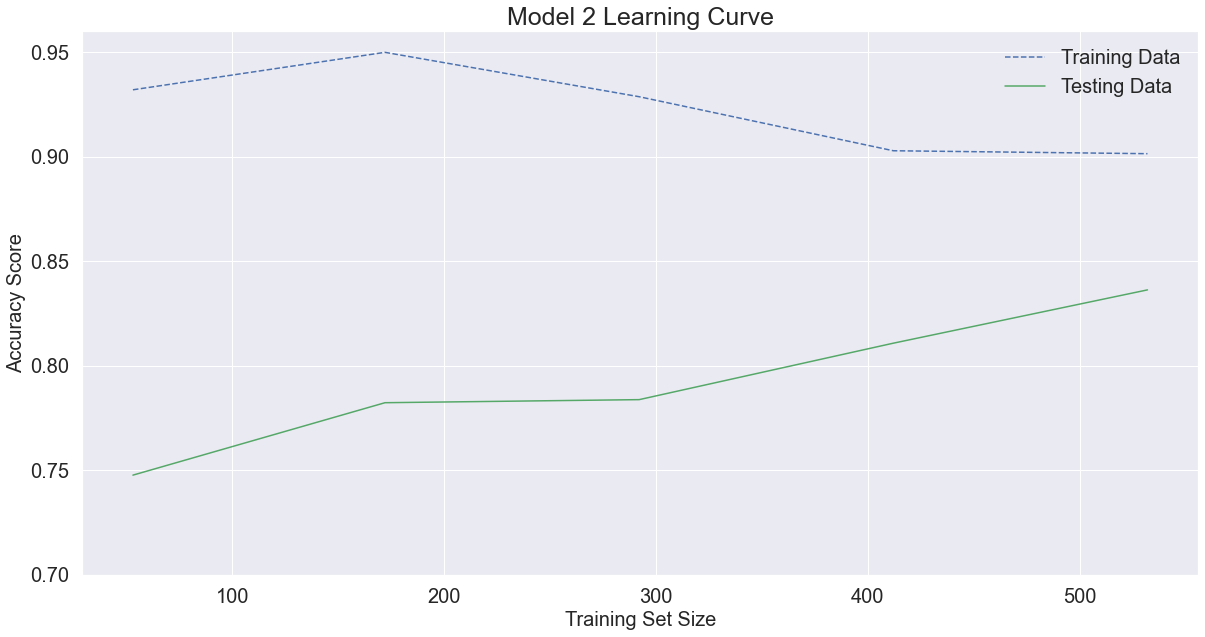

In [28]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, 
                                                            cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean,'--', color="b", label='train')
plt.plot(train_sizes, test_scores_mean, label='test', color="g")
plt.xlabel('Training Set Size', fontsize=20)
plt.ylabel('Accuracy Score', fontsize=20)
plt.title('Model 2 Learning Curve', fontsize=25)
plt.yticks([0.70,0.75,0.80,0.85,0.90,0.95])
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.legend(['Training Data','Testing Data'], fontsize=20);

The model 2 learning curve graph shows that there is relatively low training error but a decent amount of variance in the data. This is caused by over-fitting our model. It is apparent from our decision tree graph that there may be some over-fitting because of a larger max_depth of 7 and max_leaf_nodes of 26.

## Model 3 

For this model, i decided to use feature selecting for deciding which variables i would keep in the dataset along with the best parameters from the previous model.

In [29]:
predictors = df2.columns[1:] # Grab all the columns except for our target
target = 'Survived'
X = df2[predictors].values # Convert to numpy array
y = df2[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

clf = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=26, min_samples_split=4, random_state=0) # Create the tree
clf.fit(X_train, y_train) # Train the tree
clf.feature_importances_

array([0.11696041, 0.07924916, 0.05594809, 0.01567474, 0.12258315,
       0.48797746, 0.        , 0.04716541, 0.        , 0.07444158])

In [30]:
df2.columns[1:]

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_n', 'Ticket_n',
       'Cabin_n', 'Embarked_n', 'Title_n'],
      dtype='object')

According to the feature selection, the columns that provide no use are Parch, Ticket_n, and Embarked_n

In [31]:
# Drop the useless columns
df2.drop(columns=['Parch', 'Ticket_n', 'Embarked_n'], inplace=True)

In [32]:
# Create new predictors
predictors = df2.columns[1:] # Grab all the columns except for our target
target = 'Survived'
X = df2[predictors].values 
y = df2[target].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Create a new Decision Tree with the parameters of the the grid search best parameters. 
clf = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=26, min_samples_split=4, random_state=0) # Create the tree
clf.fit(X_train, y_train) # Train the tree

# Make predictions
y_predict = clf.predict(X_test)

# Check accuracy
print("Our third models accuracy is {:.2f}%".format((y_predict == y_test).mean() * 100))

Our third models accuracy is 78.92%


_Our second models accuracy was 79.37%_

_Our first models accuracy was 74.89%_

_Our baseline accuracy was 59.19%_

In [33]:
print_conf_mtx(y_test, y_predict, classes=target_names)

       predicted 
actual    No  Yes
No       114   18
Yes       29   62


The predictions of this model are nearly identical to the last model

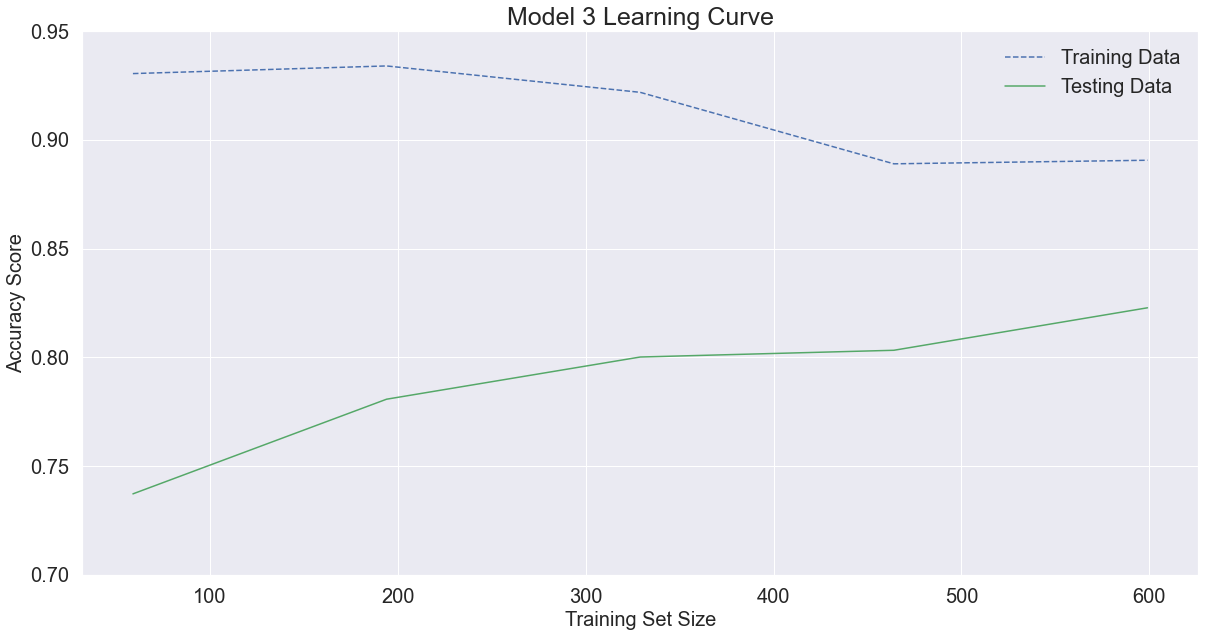

In [34]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, 
                                                            cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean,'--', color="b", label='train')
plt.plot(train_sizes, test_scores_mean, label='test', color="g")
plt.xlabel('Training Set Size', fontsize=20)
plt.ylabel('Accuracy Score', fontsize=20)
plt.title('Model 3 Learning Curve', fontsize=25)
plt.yticks([0.70,0.75,0.80,0.85,0.90,0.95])
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.legend(['Training Data','Testing Data'], fontsize=20);

From the graph, we can see there is still high variance in the data. 

## Model 4

For this model, i increased the parameters in the grid search as well as the cross validation to 10 in hopes of getting an accuracy in the 80%+. I used the same test and training data from the last two models as well. 

In [35]:
# I also increased some of the parameters to see if that gives us any better results
params = {'max_leaf_nodes': list(range(2, 100)),
          'min_samples_split': [2, 3, 4, 5, 6, 7],
          'max_depth': list(range(2,20))} 

# Increased the Cross Validations to 10
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                              params, verbose=1, cv=10, n_jobs=-1, return_train_score=True)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_params_

Fitting 10 folds for each of 10584 candidates, totalling 105840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 3624 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 19624 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 42024 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 70824 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 104785 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 105817 out of 105840 | elapsed:   43.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 105840 out of 105840 | elapsed:   43.6s finished


{'max_depth': 4, 'max_leaf_nodes': 8, 'min_samples_split': 2}

Increasing the Cross Validation to 10 gave best parameters that were smaller than our previous models

In [36]:
clf = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8, min_samples_split=2, random_state=0) # Create the tree
clf.fit(X_train, y_train) # Train the tree

# Lets check our predictions
y_predict = clf.predict(X_test)

# Check for accuracy
print("Our fourth models accuracy is {:.2f}%".format((y_predict == y_test).mean() * 100))

Our fourth models accuracy is 78.48%


_Our third models accuracy was 78.92%_

_Our second models accuracy was 79.37%_

_Our first models accuracy was 74.89%_

_Our baseline accuracy was 59.19%_

Even though the accuracy was a little lower than the second models score (79.37%), this model has smaller features than the last two. So the trade-off is having a higher accuracy score with a more complex model, or having a simpler one that has a slightly less accuracy. 

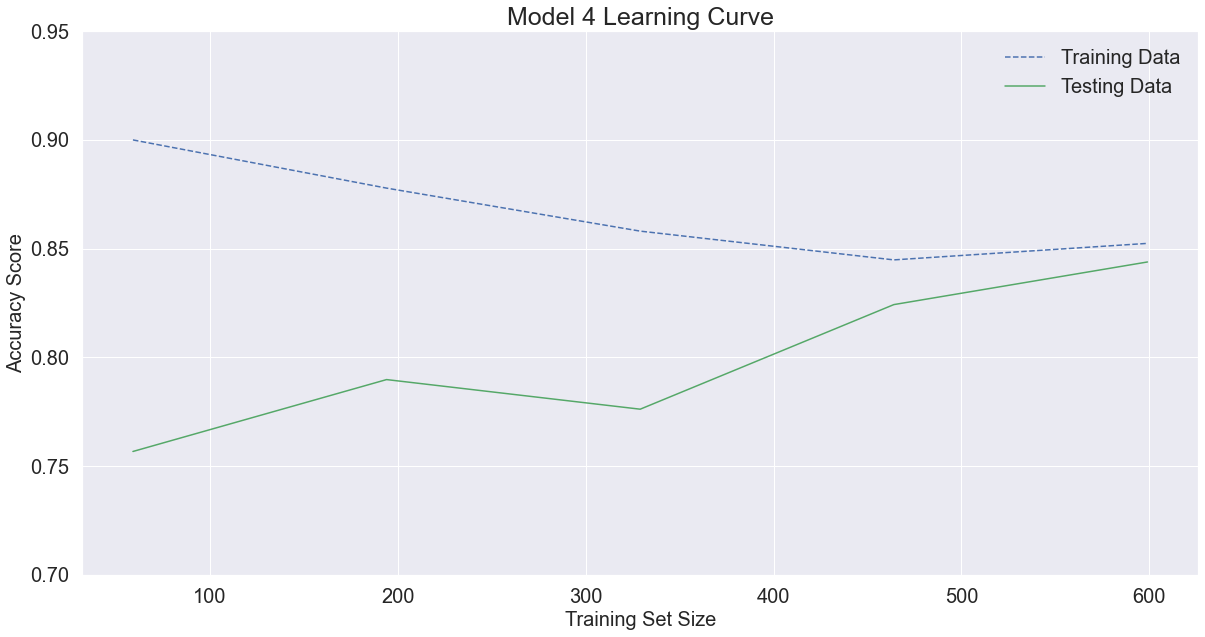

In [37]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, 
                                                            cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean,'--', color="b", label='train')
plt.plot(train_sizes, test_scores_mean, label='test', color="g")
plt.xlabel('Training Set Size', fontsize=20)
plt.ylabel('Accuracy Score', fontsize=20)
plt.title('Model 4 Learning Curve', fontsize=25)
plt.yticks([0.70,0.75,0.80,0.85,0.90,0.95])
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.legend(['Training Data','Testing Data'], fontsize=20);

The learning curve for our 4th model no longer has a high variance but now has a high bias. 

## Model 5

For my last model, i turned all the categorical variables represented as numeric into dummy variables to try to increase my accuracy

In [38]:
# Create a new df copy
df5 = df.copy()

# Convert everything into a dummy variable
df5[['Pclass','SibSp','Sex','Cabin','Title','Embarked']] = df5[['Pclass','SibSp','Sex','Cabin','Title','Embarked']].astype(object)
df5 = pd.get_dummies(df5)

In [39]:
# Create new predictors
predictors = df5.columns[1:] # Grab all the columns except for our target
target = 'Survived'
X = df5[predictors].values 
y = df5[target].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [40]:
# Find the best new parameters using the new data
params = {'max_leaf_nodes': list(range(2, 100)),
          'min_samples_split': [2, 3, 4, 5, 6, 7],
          'max_depth': list(range(2,20))} 

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                              params, verbose=1, cv=10, n_jobs=-1, return_train_score=True)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_params_

Fitting 10 folds for each of 10584 candidates, totalling 105840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 21736 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 36136 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 53736 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 74536 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 98536 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 105840 out of 105840 | elapsed:  1.2min finished


{'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 4}

In [41]:
clf = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30, min_samples_split=4, random_state=0) # Create the tree
clf.fit(X_train, y_train) # Train the tree
# Find the important features
clf.feature_importances_

array([0.07636393, 0.02562681, 0.        , 0.14764407, 0.03753629,
       0.        , 0.10878632, 0.        , 0.03287189, 0.        ,
       0.        , 0.        , 0.01747853, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00998173, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01213749, 0.        , 0.        , 0.02400001,
       0.        , 0.50757293, 0.        , 0.        ])

We now have a lot of unimportant features that we can get rid of

In [42]:
result = []
mask = (clf.feature_importances_ > 0.05) # Choose features that have more than a 5% importance
col_mask = df5.columns[1:].where(mask)
for col in np.array(col_mask):
    if type(col) != float:
        result.append(col)
result

['Age', 'Fare', 'Pclass_3', 'Title_Mr.']

These are our new important features

In [43]:
# Create a new dataframe with the feature selection
result.append('Survived')
df5 = df5[result]

predictors = df5.columns[:len(result)-1] # Grab all the columns except for our target
target = 'Survived'
X = df5[predictors].values 
y = df5[target].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Do a new grid search to see if any parameters change with the new columns
params = {'max_leaf_nodes': list(range(2, 50)),
          'min_samples_split': [2, 3, 4, 5, 6, 7],
          'max_depth': list(range(2,20))} 

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                              params, verbose=1, cv=10, n_jobs=-1, return_train_score=True)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_params_

Fitting 10 folds for each of 5184 candidates, totalling 51840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 3560 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 19560 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 41960 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 51840 out of 51840 | elapsed:   22.9s finished


{'max_depth': 11, 'max_leaf_nodes': 23, 'min_samples_split': 7}

In [44]:
# Create our 5th model
clf = DecisionTreeClassifier(max_depth=11, max_leaf_nodes=23, min_samples_split=7, random_state=0) # Create the tree
clf.fit(X_train, y_train) # Train the tree

# Lets check our predictions
y_predict = clf.predict(X_test)

# Check for accuracy
print("Our fifth models accuracy is {:.2f}%".format((y_predict == y_test).mean() * 100))

Our fifth models accuracy is 80.27%


_Our fourth models accuracy was 78.48%_

_Our third models accuracy was 78.92%_

_Our second models accuracy was 79.37%_

_Our first models accuracy was 74.89%_

_Our baseline accuracy was 59.19%_

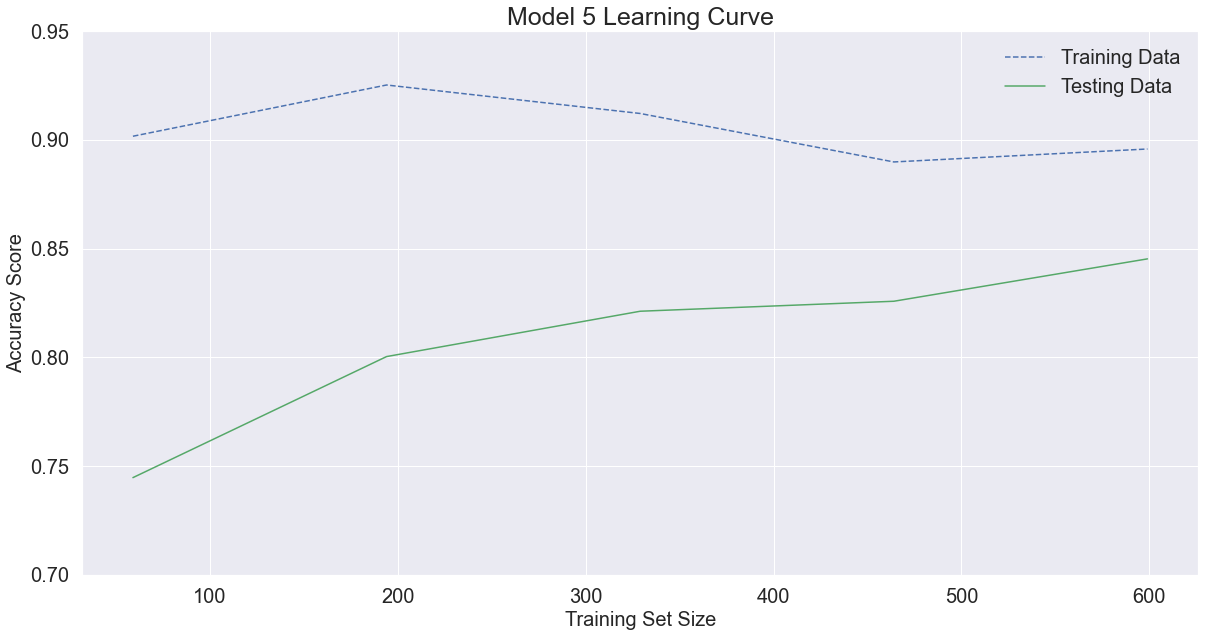

In [45]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, 
                                                            cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean,'--', color="b", label='train')
plt.plot(train_sizes, test_scores_mean, label='test', color="g")
plt.xlabel('Training Set Size', fontsize=20)
plt.ylabel('Accuracy Score', fontsize=20)
plt.title('Model 5 Learning Curve', fontsize=25)
plt.yticks([0.70,0.75,0.80,0.85,0.90,0.95])
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.legend(['Training Data','Testing Data'], fontsize=20);

Converting all the categorical data into numeric dummy data, then using cross validation and grid search created the my most accurate model

## Conclusions

Out of the 5 models i created, i am a happy that i was able to get my accuracy above 80%. The predictors that were the most useful when i converted the categorical data into numeric categorical data were the Age, Fare, Pclass_3, and Title_Mr. Using a 5% important filter in deciding the feature selection i believe also helped.

When i converted the categorical data into dummy variables, the most useful columns were only Age, Fare, Pclass_1, Pclass_3, Sex_n_0, and Title_n_3. 

I was surprised to see that my last model had the best accuracy given the predictors that the feature selection chose.  

My predictions made from the second, third, fourth, and fifth models all had improvements over the first model and the baseline. Each model had it's own problems that were highlighted in the learning curves. 